In [1]:
%load_ext autoreload
%autoreload 2

In [289]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import math
import PIL.Image as Img
from unet import UNet

In [290]:
def noisify_batch(x0, timestamps, alpha_hat):
    # x0: (B, C, H, W)
    # timestamps: (B,)
    selected_alphas = alpha_hat[timestamps][:, None, None, None]
    eps = torch.randn_like(x0)
    x_t = torch.sqrt(selected_alphas) * x0 + torch.sqrt(1 - selected_alphas) * eps
    return x_t, eps

def get_x0_given_eps(x_t, eps, timestamps, alpha_hat):
    # x0: (B, C, H, W)
    # timestamps: (B,)
    selected_alphas = alpha_hat[timestamps][:, None, None, None]
    x0 = (x_t - torch.sqrt(1 - selected_alphas) * eps) / torch.sqrt(selected_alphas)
    return x0


#def noisify_image_one_step(x_t, beta):
#    # for visualizations
#    eps = torch.randn_like(x_t)
#    return math.sqrt(1 - beta) * x_t + math.sqrt(beta) * eps

In [342]:
#class ZTransform:
#   # variance preserving diffusion
#   def __call__(self, tensor):
#       mean = tensor.mean()
#       std = tensor.std()
#       return (tensor - mean) / (std + 1.0e-7)

class MNIST_Normalized(torch.utils.data.Dataset):
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((32, 32)),
            transforms.Lambda(lambda x: x*2-1)  # [–1,1]
        ])
        self.mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=self.transforms)
    
    def __getitem__(self, idx):
        return self.mnist[idx][0]
    
    def __len__(self):
        return len(self.mnist)

In [343]:
mnist = MNIST_Normalized()

In [348]:
T = 1000
beta_start = 1.0e-4
beta_end = 2.0e-2
beta = torch.cat([torch.zeros(1, device='cuda'), torch.linspace(beta_start, beta_end, steps=T, device='cuda')], dim=0)
alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, dim=0)

n_epochs = 40
log_steps = 50
bs=128
lr=1.0e-4
wd=1.0e-4

In [349]:
model = UNet(
    image_channels=1,
    n_channels=16,
    n_blocks=1,
    is_attn=(False, False, True, True)
)
model.train()
model.cuda()

dataloader = torch.utils.data.DataLoader(
    mnist,
    batch_size=bs,
    shuffle=True,
    num_workers=16
)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=lr,
    weight_decay=wd
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=n_epochs*len(mnist) / bs,
    eta_min=lr/10    
)
loss_history = []
avg_loss = 0
step = 0
for epoch_idx in range(n_epochs):
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
        batch = batch.cuda()
        timestamps = torch.randint(1, T+1, size=(batch.shape[0],), device='cuda').long()
        x_t, gt_eps = noisify_batch(batch, timestamps, alpha_hat)
        pred_eps = model(x_t, timestamps.float())
        loss = F.mse_loss(pred_eps, gt_eps)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (step + 1) % log_steps == 0:
            avg_loss /= log_steps
            print(f'Epoch {epoch_idx} Step: {step} Loss: {avg_loss:.3f} LR: {optimizer.param_groups[0]['lr']}')
            loss_history.append(avg_loss)
            avg_loss = 0
        step += 1

Epoch 0 Step: 49 Loss: 0.789 LR: 9.999842087253161e-05
Epoch 0 Step: 99 Loss: 0.347 LR: 9.999368360095506e-05
Epoch 0 Step: 149 Loss: 0.227 LR: 9.998578851774846e-05
Epoch 0 Step: 199 Loss: 0.174 LR: 9.997473617701582e-05
Epoch 0 Step: 249 Loss: 0.148 LR: 9.996052735444852e-05
Epoch 0 Step: 299 Loss: 0.126 LR: 9.994316304727067e-05
Epoch 0 Step: 349 Loss: 0.114 LR: 9.992264447416918e-05
Epoch 0 Step: 399 Loss: 0.101 LR: 9.989897307520801e-05
Epoch 0 Step: 449 Loss: 0.098 LR: 9.987215051172756e-05
Epoch 1 Step: 499 Loss: 0.088 LR: 9.984217866622762e-05
Epoch 1 Step: 549 Loss: 0.085 LR: 9.98090596422355e-05
Epoch 1 Step: 599 Loss: 0.079 LR: 9.977279576415839e-05
Epoch 1 Step: 649 Loss: 0.072 LR: 9.973338957712012e-05
Epoch 1 Step: 699 Loss: 0.069 LR: 9.969084384678252e-05
Epoch 1 Step: 749 Loss: 0.066 LR: 9.964516155915149e-05
Epoch 1 Step: 799 Loss: 0.063 LR: 9.959634592036715e-05
Epoch 1 Step: 849 Loss: 0.062 LR: 9.954440035647916e-05
Epoch 1 Step: 899 Loss: 0.057 LR: 9.948932851320603

KeyboardInterrupt: 

In [350]:
model.eval()

UNet(
  (image_proj): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=16, out_features=64, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=64, out_features=64, bias=True)
  )
  (down): ModuleList(
    (0): DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act2): Swish()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=64, out_features=16, bias=True)
        (time_act): Swish()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (1): Downsample(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (2): D

In [356]:
def ddpm_posterior_sample(x_t, predicted_eps, beta, alpha_hat, t: int):
    if t == 0:
        raise ValueError('t=0 encountered')
    #x0_pred = predicted_eps#get_x0_given_eps(x_t, predicted_eps, torch.tensor([t], dtype=torch.long, device='cuda'), alpha_hat)

    a_tm1 = alpha_hat[t-1]      # tensor
    a_t   = alpha_hat[t]        # tensor
    b_t   = beta[t]             # tensor

    #coef1 = torch.sqrt(a_tm1) * b_t/(1 - a_t)
    #coef2 = torch.sqrt(1 - b_t)*(1 - a_tm1)/(1 - a_t)
    std_coef   = torch.sqrt(b_t*(1 - a_tm1)/(1 - a_t))

    #mu = coef1 * x0_pred + coef2 * x_t

    #sample = torch.randn_like(x_t) * std_coef + mu

    sample = (1 / torch.sqrt(1-b_t)) * (x_t -  (b_t / torch.sqrt(1 - a_t)) * predicted_eps) + torch.randn_like(x_t) * std_coef
    return sample


def generate_image(model, T, beta):
    x = torch.randn(15, 1, 32, 32, device='cuda')
    #x = noisify_batch(mnist[0].unsqueeze(0).cuda(), torch.tensor([1000], dtype=torch.long, device='cuda'), alpha_hat)[0]
    history = []

    for t in range(T, 0, -1):
        #if t % 10 == 0:
        #    history.append(x[0, 0].cpu())

        with torch.no_grad():
            timestamps = torch.tensor([t] * 15, dtype=torch.float32, device='cuda')
            pred_eps = model(x, timestamps)

        x = ddpm_posterior_sample(x, pred_eps, beta, alpha_hat, t)
    return x.clamp(-1, 1)


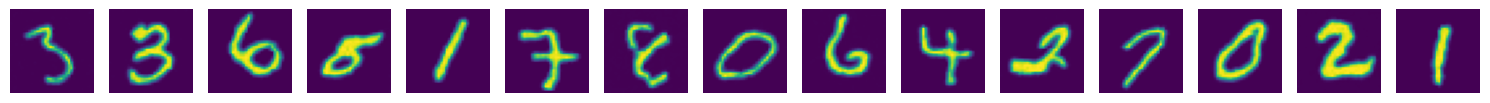

In [357]:
history = generate_image(model, T=T, beta=beta)
last_five = history.cpu().detach()#[-5:]

fig, axes = plt.subplots(1, 15, figsize=(15, 3))

for ax, img in zip(axes, last_five):
    ax.imshow(img.permute(1, 2, 0).float() / 2 + 0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()
#plt.imshow(img)
#plt.show()
